## 2022 TBA Predictions

Match data is fetched from TBA by running fetchMatches.py.  Run this first before running this notebook.

`python fetchMatches.py`


In [1]:
from __future__ import print_function
import pickle
#import time
import sys
from collections import Counter

sys.path.append('..')
import swagger_client as v3client
from swagger_client.rest import ApiException

fetch_matches = False
if fetch_matches:
    from fetchMatches import fetch_all_matches
    fetch_all_matches(2022)


In [2]:
# load all the matches

filename = 'matches_2022.pkl'
matches = []
with open(filename, 'rb') as f:
    matches = pickle.load(f)

Filter the matches to completed matches

In [3]:
non_empty = [k for k in matches['matches'].keys() if len(matches['matches'][k])>0]
data = [m for k in matches['matches'] for m in matches['matches'][k]]
data = [m for m in data if m.winning_alliance!='']
print(len(data))
#red = [x for m in data for x in m.alliances.red.team_keys]
#blue = [x for m in data for x in m.alliances.blue.team_keys]
#from collections import Counter
#Counter(red+blue)

5742


Most match fields are numeric but some will need special treatment. Here we enumerate string and boolean fields.

In [4]:

data[0].score_breakdown['blue'].keys()

endgameFields = Counter()
taxiFields = Counter()
for d in data:
   endgameFields[d.score_breakdown['blue']['endgameRobot1']]+=1
   endgameFields[d.score_breakdown['blue']['endgameRobot2']]+=1
   endgameFields[d.score_breakdown['blue']['endgameRobot3']]+=1
   taxiFields[d.score_breakdown['blue']['taxiRobot1']]+=1
   taxiFields[d.score_breakdown['blue']['taxiRobot2']]+=1
   taxiFields[d.score_breakdown['blue']['taxiRobot3']]+=1
print(endgameFields)
print(taxiFields)

for k in d.score_breakdown['blue']:
   if type(d.score_breakdown['blue'][k]) is not int:
      print(k, type(d.score_breakdown['blue'][k]))


Counter({'None': 9212, 'Mid': 4426, 'Traversal': 1943, 'High': 1140, 'Low': 505})
Counter({'Yes': 13301, 'No': 3925})
cargoBonusRankingPoint <class 'bool'>
endgameRobot1 <class 'str'>
endgameRobot2 <class 'str'>
endgameRobot3 <class 'str'>
hangarBonusRankingPoint <class 'bool'>
quintetAchieved <class 'bool'>
taxiRobot1 <class 'str'>
taxiRobot2 <class 'str'>
taxiRobot3 <class 'str'>


In [5]:
# Finals, quarterfinales, qualifiers, semifinals
Counter([x.comp_level for x in data])

Counter({'f': 159, 'qf': 651, 'qm': 4613, 'sf': 319})

In [6]:
# We'll only train based on qualifier matches

qualifiers = [x for x in data if x.comp_level=='qm'] 

In [35]:
# ['adjustPoints', 'autoCargoLowerBlue', 'autoCargoLowerFar', 'autoCargoLowerNear', 'autoCargoLowerRed', 
# 'autoCargoPoints', 'autoCargoTotal', 'autoCargoUpperBlue', 'autoCargoUpperFar', 'autoCargoUpperNear', 
# 'autoCargoUpperRed', 'autoPoints', 'autoTaxiPoints', 'cargoBonusRankingPoint', 'endgamePoints', 
# 'endgameRobot1', 'endgameRobot2', 'endgameRobot3', 
# 'foulCount', 'foulPoints', 'hangarBonusRankingPoint', 'matchCargoTotal', 'quintetAchieved', 'rp', 
# 'taxiRobot1', 'taxiRobot2', 'taxiRobot3', 'techFoulCount', 
# 'teleopCargoLowerBlue', 'teleopCargoLowerFar', 'teleopCargoLowerNear', 'teleopCargoLowerRed', 
# 'teleopCargoPoints', 'teleopCargoTotal', 'teleopCargoUpperBlue', 'teleopCargoUpperFar', 'teleopCargoUpperNear', 
# 'teleopCargoUpperRed', 'teleopPoints', 'totalPoints']

# endgame: None': 6246, 'Mid': 2854, 'Traversal': 1177, 'High': 780, 'Low': 325}

teamAggregates = {}


import re
def matchAlliance(column, alliance):    
    m = re.match('(.*)(Red|Blue)', column)
    if m:
        if m.groups()[1].lower()==alliance:
            column = m.groups()[0]+'Same'
        else:
            column = m.groups()[0]+'Opp'        
    return column

def addMatch(team, m):    
    if team not in teamAggregates:       
        # initialize an empty record for the team.
        teamAggregates[team]= {
            'plusMinus':0,
            'totalMatches':0, 
            'winCount': 0
        }
        for k in m.score_breakdown['blue'].keys():            
            val = m.score_breakdown['blue'][k]
            k = matchAlliance(k, 'blue')
            if type(val) is int or type(val) is bool:
                teamAggregates[team][f'{k}Total'] = 0            
            
        for r in [1,2,3]:
            for v in ['Yes', 'No']:
                teamAggregates[team][f'taxiRobot{r}{v}Total'] = 0
            for e in ['None', 'Mid', 'Traversal', 'High', 'Low']:
                teamAggregates[team][f'endgameRobot{r}{e}Total'] = 0 
        
    # TODO: we aren't accounting for alliance color when we 
    # accumulate fields like autoCargoUpperBlue/Red.  Does this matter? [need to read the rules]
    alliance = 'blue' if team in m.alliances.blue.team_keys else 'red'
    oppalliance = 'red' if team in m.alliances.blue.team_keys else 'blue'
    
    points = m.score_breakdown[alliance]
    summary = teamAggregates[team]
    # update all of the fields.
    summary['totalMatches']+=1    
    
    # TODO: figure out if we are robot 1, 2, or 3.
    for r in [1, 2, 3]:        
        summary[f'taxiRobot{r}{points[f"taxiRobot{r}"]}Total'] += 1
        summary[f'endgameRobot{r}{points[f"endgameRobot{r}"]}Total'] += 1

    for k in points.keys():
        if type(points[k]) is int:
            target = matchAlliance(k, alliance)
            summary[f'{target}Total'] += points[k]
        elif type(points[k]) is bool:
            summary[f'{k}Total'] += int(points[k])

    plusminus = points['teleopPoints'] - m.score_breakdown[oppalliance]['teleopPoints']
    summary['plusMinus'] += plusminus
    summary['winCount'] += int(m.winning_alliance==alliance)


for m in qualifiers:    
    for t in m.alliances.red.team_keys:
        addMatch(t,m)
    for t in m.alliances.blue.team_keys:
        addMatch(t,m)
        
# normalize the aggregates
for t in teamAggregates:
    for k in teamAggregates[t]:
        if k=='totalMatches':
            continue
        teamAggregates[t][k]/=teamAggregates[t]['totalMatches']

with open('teamStats_2022.pkl','wb') as f:
    pickle.dump(teamAggregates,f)

In [32]:
teamAggregates['frc492']

{'plusMinus': 0.0,
 'totalMatches': 24,
 'winCount': 0.625,
 'adjustPointsTotal': 0.0,
 'autoCargoLowerSameTotal': 0.041666666666666664,
 'autoCargoLowerFarTotal': 0.125,
 'autoCargoLowerNearTotal': 0.08333333333333333,
 'autoCargoLowerOppTotal': 0.125,
 'autoCargoPointsTotal': 10.083333333333334,
 'autoCargoTotalTotal': 2.7083333333333335,
 'autoCargoUpperSameTotal': 0.5833333333333334,
 'autoCargoUpperFarTotal': 0.4583333333333333,
 'autoCargoUpperNearTotal': 0.5833333333333334,
 'autoCargoUpperOppTotal': 0.7083333333333334,
 'autoPointsTotal': 14.333333333333334,
 'autoTaxiPointsTotal': 4.25,
 'cargoBonusRankingPointTotal': 0.4583333333333333,
 'endgamePointsTotal': 12.416666666666666,
 'foulCountTotal': 0.5416666666666666,
 'foulPointsTotal': 2.3333333333333335,
 'hangarBonusRankingPointTotal': 0.2916666666666667,
 'matchCargoTotalTotal': 18.041666666666668,
 'quintetAchievedTotal': 0.125,
 'rpTotal': 2.0,
 'techFoulCountTotal': 0.0,
 'teleopCargoLowerSameTotal': 0.7916666666666666

Now we have statistics for every team.  We can use this to generate features for every match.

In [15]:

def featurizeAlliances(red, blue, label=0, comp_level='qm', event='none'):
    match_features = { 'red_missingCount':0, 'blue_missingCount': 0 }
    count=0    
    allKeys = set()
    for t in red:
        if t not in teamAggregates:
            match_features['red_missingCount']+=1
            continue
        for k in teamAggregates[t]:
            key = 'red_'+k
            if key not in match_features:
                match_features[key]=0
            match_features[key]+=teamAggregates[t][k]
            allKeys.add(key)
        count+=1
    # compute the average
    for k in allKeys:
        match_features[k]/=count
    count=0
    allKeys=set()
    for t in blue:
        if t not in teamAggregates:
            match_features['blue_missingCount']+=1
            continue
        for k in teamAggregates[t]:
            key = 'blue_'+k
            if key not in match_features:
                match_features[key]=0
            match_features[key]+=teamAggregates[t][k]
            allKeys.add(key)
        count+=1
    # compute the average
    for k in allKeys:
        match_features[k]/=count
    match_features['event']= event
    match_features['comp_level']= comp_level
    match_features['label']= label    
    return match_features

def featurizeMatch(m):
    return featurizeAlliances(
        m.alliances.red.team_keys, 
        m.alliances.blue.team_keys, 
        label=int(m.winning_alliance=='red'), # Positive label == red alliance won
        event = m.event_key, comp_level=m.comp_level)


def invertMatch(f):
    f2={}
    for k in f:
        k2 = k.replace('red_','temp_').replace('blue_','red_').replace('temp_','blue_')
        f2[k2]=f[k]
    f2['label']=1-f['label']
    return f2

features = []

for m in data:
    f = featurizeMatch(m)
    features.append(f)
    #features.append(invertMatch(f))
    
features[0]

{'red_missingCount': 0,
 'blue_missingCount': 0,
 'red_totalMatches': 13.0,
 'red_winCount': 0.5384615384615384,
 'red_adjustPointsTotal': 0.0,
 'red_autoCargoLowerSameTotal': 0.15384615384615385,
 'red_autoCargoLowerFarTotal': 0.15384615384615385,
 'red_autoCargoLowerNearTotal': 0.10256410256410257,
 'red_autoCargoLowerOppTotal': 0.25641025641025644,
 'red_autoCargoPointsTotal': 8.0,
 'red_autoCargoTotalTotal': 2.307692307692308,
 'red_autoCargoUpperSameTotal': 0.3846153846153846,
 'red_autoCargoUpperFarTotal': 0.3076923076923077,
 'red_autoCargoUpperNearTotal': 0.5128205128205129,
 'red_autoCargoUpperOppTotal': 0.4358974358974359,
 'red_autoPointsTotal': 12.41025641025641,
 'red_autoTaxiPointsTotal': 4.410256410256411,
 'red_cargoBonusRankingPointTotal': 0.23076923076923075,
 'red_endgamePointsTotal': 13.076923076923078,
 'red_foulCountTotal': 0.4358974358974359,
 'red_foulPointsTotal': 2.358974358974359,
 'red_hangarBonusRankingPointTotal': 0.4102564102564103,
 'red_matchCargoTotalT

In [16]:
from sklearn.feature_extraction import DictVectorizer
# create train and test sets
train = []
trainY = []
test = []
testY = []

for m in features:    
    if 'event' not in m:
        print(m)
    event = m['event']
    comp_level = m['comp_level']
    del m['event']
    del m['comp_level']
    
    label = m['label']
    del m['label']
    
    # Train on qualifiers. Test on everything else.
    if comp_level!='qm':
        test.append(m)
        testY.append(label)
    else:
        train.append(m)
        trainY.append(label)
        
vectorizer = DictVectorizer()
trainX = vectorizer.fit_transform(train)
testX = vectorizer.transform(test)

print('{} training examples and {} test'.format(len(train),len(test)))


4613 training examples and 1129 test


In [17]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=0, min_samples_split=3)  
classifier.fit(trainX,trainY)
forest_predictions= classifier.predict(testX)
forest_scores = classifier.predict_proba(testX)
import numpy as np
from sklearn.metrics import accuracy_score
#np.sum(np.abs(scores-Ytest))
print('accuracy: {}'.format(accuracy_score(testY, forest_predictions)))
#list(zip(forest_scores[:,1],testY))

# Save the model
model_fn = 'model_2022_forest.pkl'
with open(model_fn, 'wb') as outF:
    pickle.dump((vectorizer,classifier), outF)


accuracy: 0.7821080602302923


Let's look at the feature importances. They tell us how useful a specific feature is.

Feature ranking:


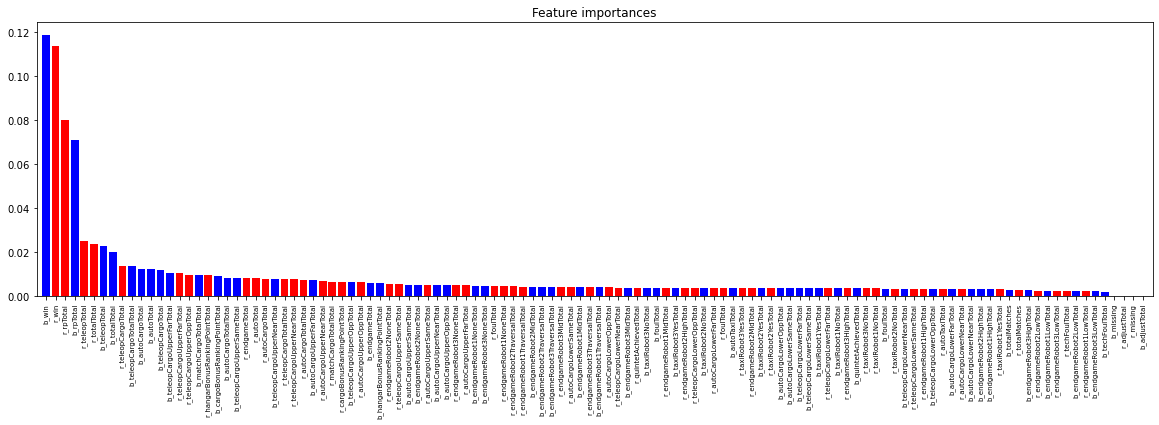

In [18]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = vectorizer.feature_names_

# Print the feature ranking
print("Feature ranking:")

#for f in range(trainX.shape[1]):
#    print("%d. %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))
colors = [names[indices[f]].split('_')[0] for f in range(trainX.shape[1])]
labels = [names[indices[f]].replace('Count','').replace('Points','').replace('red','r').replace('blue','b') for f in range(trainX.shape[1])]
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
plt.figure()
plt.title("Feature importances")
plt.bar(range(trainX.shape[1]), importances[indices],
       color=colors, 
        #yerr=std[indices], 
        align="center")
plt.xticks(range(trainX.shape[1]), labels, rotation='vertical', fontsize='x-small')
    
plt.xlim([-1, trainX.shape[1]])
plt.subplots_adjust(bottom=0.5)
#plt.legend()
plt.show()

In [19]:
def percentile(dictionary, key):
    teams = [t for t in dictionary]
    values = [dictionary[t][key] for t in dictionary]
    ranks = sorted(range(len(values)), key=lambda x: values[x])
    return dict([(teams[ranks[i]], i*100/len(values)) for i in range(len(ranks))])    

raw = dict([(k, percentile(teamAggregates,k)) for k in teamAggregates['frc1153']])
#stats = dict([(k,percentile(teamAggregates,k)['frc1153']) for k in teamAggregates['frc1153']])

The next cell enables comparisons between two teams.

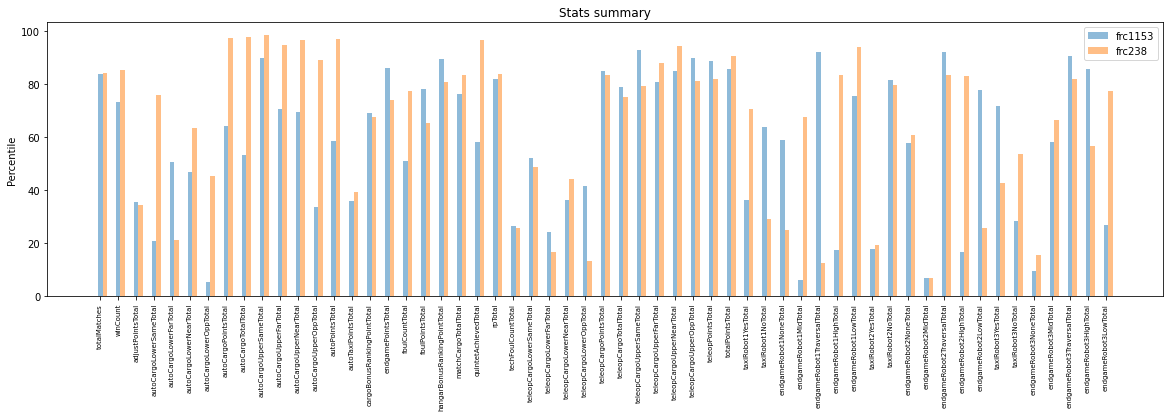

In [20]:
import matplotlib.pyplot as plt
import numpy as np

objects = [k for k in raw]
y_pos = np.arange(len(objects))
#performance = [[raw[k]['frc492'],raw[k]['frc2910']] for k in stats]
#performance
t1 = 'frc1153'
t2 = 'frc238'
plt.figure()
plt.bar(y_pos, [raw[k][t1] for k in raw], alpha=0.5, width=0.25)
plt.bar(y_pos+0.25, [raw[k][t2] for k in raw], alpha=0.5, width=0.25)
plt.xticks(y_pos, objects, rotation=90, fontsize='x-small')
plt.subplots_adjust(bottom=0.5)
plt.ylabel('Percentile')
plt.title('Stats summary')
plt.legend([t1,t2])

plt.show()


So far our best score at predicting the districts is 0.78 using either RandomForests.  Next time we can explore hyperparameter tuning and also predicting which alliances would have been the best ones for us to join.

Next steps: for a given event we want to decide how to prioritize alliance choices.  Suppose we have all the data to date, as well as all the qualifier data for the event. Who should we choose as partners?

In [25]:
# optimize alliances for frc492 at wasno:
import random
from tqdm import tqdm

event = '2022wasam'
teams = set([t for x in \
    [m.alliances.red.team_keys + m.alliances.blue.team_keys for m in matches['matches'][event]] \
        for t in x])

model_fn = 'model_2022_forest.pkl'
with open(model_fn, 'rb') as inF:
    vectorizer, model = pickle.load(inF)

# wasno
taken_wasno = [
    'frc2910', 'frc4089', 'frc7461', 'frc2930', 
    'frc2522', 'frc4911', 'frc4512', 'frc492',
    'frc7627', 'frc2903', 'frc4682', 'frc2412',
    'frc1778', 'frc4173', 'frc2980', 'frc4131',
    'frc3663', 'frc1899', 'frc5827', 'frc5588'
]

taken_wasam_round1 = [
    4911, 5827, 488, 3218, 492
]

taken_wasam = [
    4911, 5827, 488, 3218, 492, 1899, 4180, 2928, 4915, 5588, 2412, 4173, 4205, 1983, 2980, 1318, 4469, 3786, 4512, 1778, 3681
]

taken = list(map(lambda x: f'frc{x}', taken_wasam))

# set to just ['frc492'] if you're ranking pairs
target = ['frc492', 'frc1899']

# If you are ranking pairs
if len(target)==1:
    partners = [[x,y] for x in teams if x!=target for y in teams if y!=target if x<y and x not in taken and y not in taken]
else:
    partners = [[x] for x in teams if x not in taken]
results = {}
features = []
alliances = []
for p in tqdm(partners): 
    red = target + p  
    candidates = [x for x in teams if x not in red]
    trials = 1000
    
    for m in range(trials):
        # Here we're sampling any possible alliance, except the members of red.    
        blue = random.sample(candidates, 3)
        f = featurizeAlliances(red, blue)
        features.append(f)
        alliances.append([red,blue])

scores = model.predict_proba(vectorizer.transform(features))
results = {}
for (p,_), score in zip(alliances, scores): 
    p = tuple(p)
    if p not in results:
        results[p] = 0
    results[p] += score[1]    


for r in list(sorted(results, key=lambda x: results[x], reverse=True))[:100]:
    print(r, results[r])

100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


('frc492', 'frc1899', 'frc1294') 815.2844523809549
('frc492', 'frc1899', 'frc4682') 762.5946666666675
('frc492', 'frc1899', 'frc7627') 739.6878571428572
('frc492', 'frc1899', 'frc3049') 699.3021666666662
('frc492', 'frc1899', 'frc4309') 682.0417619047632
('frc492', 'frc1899', 'frc2929') 648.4375714285705
('frc492', 'frc1899', 'frc4579') 646.7045714285715
('frc492', 'frc1899', 'frc949') 634.1031428571422
('frc492', 'frc1899', 'frc5683') 623.7573809523815
('frc492', 'frc1899', 'frc948') 573.3445714285713


In [22]:
[(p,teamAggregates[p]['winCount']) for p in partners]

TypeError: unhashable type: 'list'